# Image Classification | CIFAR-10 with ResNet50

### 1 - Notebook Overview

This notebook builds an image classification model using **transfer learning** with a pre-trained `ResNet50` network to categorize `CIFAR-10` images into 10 classes. The workflow follows a two-phase training approach:

- **Data Loading:** Loading the `CIFAR-10` dataset and limiting to 10,000 training samples.
- **Preprocessing:** Normalizing pixel values for `ResNet50` compatibility.
- **Model Architecture:** Using `ResNet50` (ImageNet weights) as a feature extractor with a custom classification head.
- **Phase 1 Training:** Training only the classification head while keeping `ResNet50` layers frozen.
- **Phase 2 Fine-tuning:** Unfreezing the base model and training end-to-end with a lower learning rate.
- **Evaluation:** Assessing model performance on the test set and analyzing training curves.

---

### 2 - Import Libraries

In [ ]:
# Core Libraries
import pandas as pd

# Data
from tensorflow.keras.datasets import cifar10

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Exclude warnings
import warnings
warnings.filterwarnings('ignore')

### 3 - Load Dataset

In [28]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [29]:
# Limit training data for faster experimentation
n = 10000
train_images = train_images[:n]
train_labels = train_labels[:n]

### 4 - Data Exploration

In [30]:
# Check dataset shapes
print("--- CIFAR-10 Dataset Shapes ---")
print(f"Training images: {train_images.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}")

--- CIFAR-10 Dataset Shapes ---
Training images: (10000, 32, 32, 3)
Training labels: (10000, 1)
Test images: (10000, 32, 32, 3)


In [31]:
#Flatten labels for further inspection
flat_labels = train_labels.flatten()

# Count images per class
pd.Series(flat_labels).value_counts().sort_index()

0    1005
1     974
2    1032
3    1016
4     999
5     937
6    1030
7    1001
8    1025
9     981
Name: count, dtype: int64

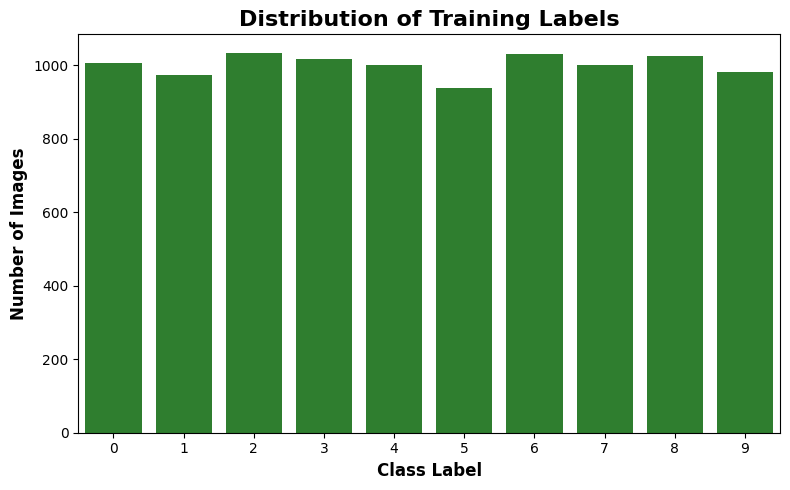

In [32]:
# Visualize label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=flat_labels, color='forestgreen')
plt.title('Distribution of Training Labels', fontsize=16, fontweight='bold')
plt.xlabel('Class Label', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [33]:
# Define class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

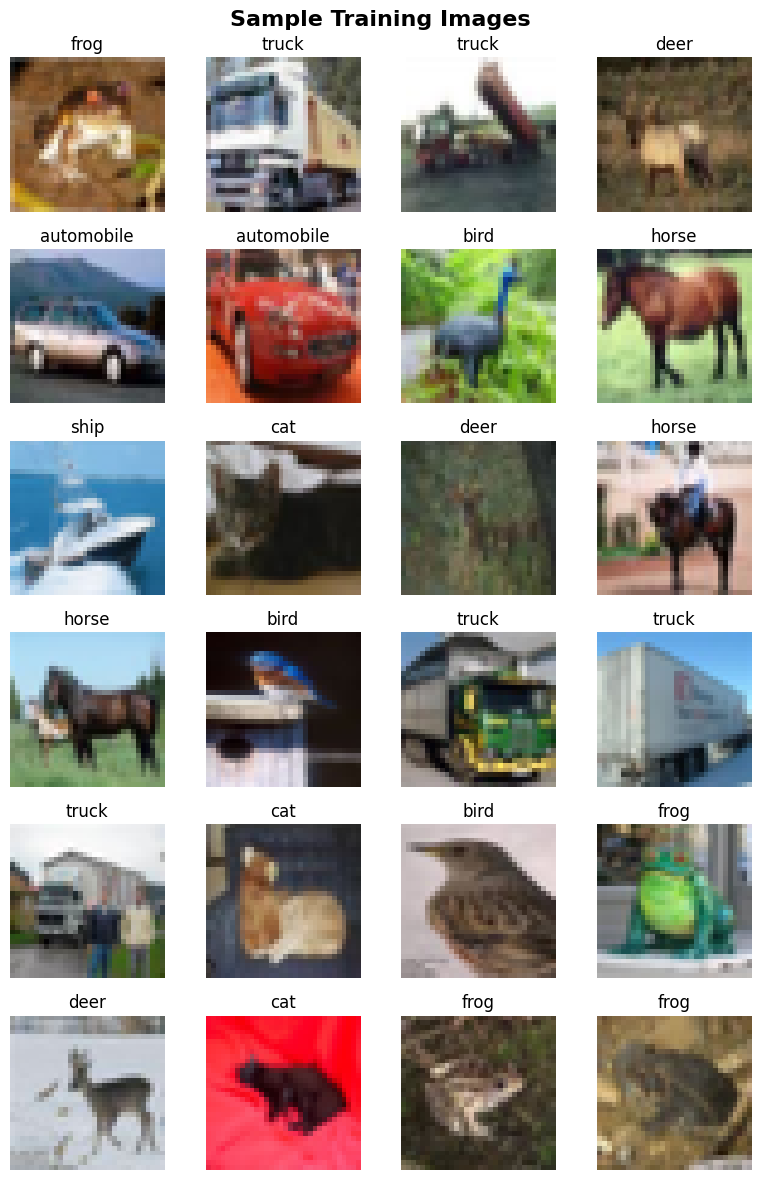

In [34]:
# View sample images
fig, axes = plt.subplots(6, 4, figsize=(8, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i])
    ax.set_title(classes[flat_labels[i]])
    ax.axis('off')

plt.suptitle('Sample Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Observations:**
- **Balanced classes:** Each class contains approximately 1,000 images (of the 10,000 sample), so no resampling or class weighting is needed.
- **Image quality:** The 32x32 resolution is low, making some objects difficult to distinguish even visually. This is a known challenge with CIFAR-10 compared to higher-resolution datasets.
- **Color images:** Unlike grayscale datasets, these RGB images contain color information that the model can leverage for classification.

### 5 - Preprocessing

Unlike traditional neural networks that require flattened input vectors, CNNs like ResNet50 expect images to retain their spatial structure (height × width × channels). The images remain as (32, 32, 3) arrays—no reshaping needed. However, neural networks train more effectively when input values are small. Normalizing raw pixel values from (0–255) to (0–1) improves gradient flow and training stability.

In [35]:
# Normalize pixel values to 0-1 range
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

### 6 - Model Architecture

In [ ]:
# Load ResNet50 base model (without top classification layer)
base_model = ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [39]:
# Freeze base model so only the custom head trains (preserves ImageNet features)
base_model.trainable = False

# Build model with custom classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# View model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

The summary confirms ~23.5M parameters are frozen (`ResNet50` base) while only ~271K parameters in the custom head are trainable. This is the intended setup for Phase 1.

### 7 - Phase 1: Train Classification Head

### 8 - Phase 2: Fine-tune Full Model

### 9 - Evaluation & Results